In [1]:
from __future__ import absolute_import, division, print_function
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from scipy.spatial.distance import cdist 
import numpy.matlib
import time
from scipy.stats import multivariate_normal
from ModelSetup_MixtureGauss import ModelSetup 
# from ModelSetup_local_concentration_d import ModelSetup 
#np.random.seed(seed=5)
from SVN_H import SVN_H_New

In [27]:
num_comp = 2
num_dim = 2
prior_m = np.random.uniform(-1.,1.,num_dim)
prior_C0 = 1.
post_m = np.random.uniform(-1.,1.,(num_comp,num_dim))
post_C = .2
design = [num_comp,num_dim,prior_m,prior_C0,post_m,post_C]
model = ModelSetup(design)
print("prior_m", prior_m )
print("post_m", post_m )

prior_m [-0.8795753  -0.29757836]
post_m [[-0.2852734   0.90672379]
 [ 0.75600143 -0.45139992]]


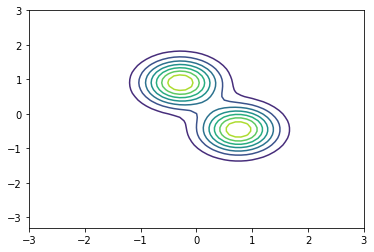

In [28]:
x1 = np.arange(-3,3.05,.1)
x2 = np.arange(-3.3,3.05,.1)
X1,X2 = np.meshgrid(x1, x2)
x_2d = np.array([X1.flatten('F'),X2.flatten('F')])
post_pdf =  model.post2contour(x_2d)
post_pdf = np.reshape(post_pdf, (x2.shape[0], x1.shape[0]),order="F")
plt.contour(X1, X2, post_pdf)
plt.show()

In [ ]:
# model = ModelSetup([1.,2.])
# x1 = np.arange(-3,3.05,.1)
# x2 = np.arange(-3.3,3.05,.1)
# X1,X2 = np.meshgrid(x1, x2)
# x_2d = np.array([X1.flatten('F'),X2.flatten('F')])
# post_pdf =  model.post2contour(x_2d)
# post_pdf = np.reshape(post_pdf, (x2.shape[0], x1.shape[0]),order="F")
# plt.contour(X1, X2, post_pdf)
# plt.show()

In [ ]:
# x1 = np.arange(-3,3.05,.1)
# x2 = np.arange(-3.3,3.05,.1)
# X1,X2 = np.meshgrid(x1, x2)
# x_2d = np.array([X1.flatten('F'),X2.flatten('F')])
# post_pdf =  model.postdcontour(x_2d,np.array([0,1]),50)
# post_pdf = np.reshape(post_pdf, (x2.shape[0], x1.shape[0]),order="F")
# plt.contour(X1, X2, post_pdf)
# plt.show()
# post_pdf2 =  model.postdcontour(x_2d,np.array([2,3]),50)
# post_pdf2 = np.reshape(post_pdf2, (x2.shape[0], x1.shape[0]),order="F")
# plt.contour(X1, X2, post_pdf2)
# plt.show()

In [29]:
N = 100
random_sample = np.random.randn(model.dim,N)
x0 = model.prior_m[:,np.newaxis] + np.dot(model.prior_C0sqrt,random_sample) 

In [30]:
    itermax = 10
    stepsize = 1
    x = x0.copy() 
    N = x.shape[1]
    
    # Initialise particle maximum shifts
    maxshift = np.zeros(N)
    maxmaxshift_old = np.inf
    
    # Initialise average computational time
    timeave = 0;
    
    # Identity matrix
    I = np.identity(model.dim)
    #print('   step norm        mean           min            median' )
    log_posterior = np.zeros(N)
    for k in range(itermax):
        tic = time.time()
        
        g_mlpt = np.zeros((model.dim, N))
        gnH = np.zeros((model.dim,model.dim,N))
        
        for j in range(N):
            logpost_pdf,logpost_grad,logpost_hess = model.logpost_stat(x[:,j])
            g_mlpt[:,j] = -logpost_grad
            gnH[:,:,j]  = -logpost_hess
        
        # Averaging Hessian approximation
        sEH = np.mean(gnH,axis=2)  / model.dim
        
        x_copy = x.copy()
        Q = np.zeros( (model.dim, N) )
        kernel = np.zeros((N,N))
        gkernel = np.zeros((N,N,model.dim))
        for i in range(N):
            sign_diff = x[:,i,np.newaxis] - x_copy
            Msd   = np.matmul(sEH, sign_diff)
            kernel[i,:]  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            gkernel[i,:,:] = (Msd * kernel[i,:]).T
        sum_k = 1.#np.sum(kernel,axis=1)
        sum_gkernel = np.sum(gkernel,axis = 0)/np.sum(kernel,axis=1)[:,np.newaxis]
        for i in range(N):       
            kern  = kernel[i,:]#np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            gkern = gkernel[i,:,:].T #Msd * kern

            mgJ = np.mean(- g_mlpt * kern + gkern , 1)
            HJ  = np.mean(gnH * kern * sum_k, 2) + np.matmul(gkern, sum_gkernel) /N
            Q[:,i] = np.linalg.solve(HJ, mgJ)
            maxshift[i] = np.linalg.norm(Q[:,i], np.inf)
        for i in range(N):
            kern_i = kernel[i,:]
            step = np.sum(Q * np.tile(kern_i[np.newaxis,:],[model.dim,1]),axis = 1)/np.sum(kernel,axis=1)[i]
                
            x[:,i] += step
            log_posterior[i],_,_ = model.logpost_stat(x[:,i])
            
            
#         for i in range(N):
#             step = 0.
#             sign_diff = x[:,i,np.newaxis] - x
#             Msd   = np.matmul(sEH, sign_diff)
#             kern = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
#             for j in range(N):
#                 step +=Q[:,j] *kern[j]
                
#             x[:,i] += step /np.sum(kernel,axis=1)[i]
#             log_posterior[i] = model.log_post(x[:,[i]])

 
        maxmaxshift = np.max(maxshift);
        #print('Maximum shift is', maxmaxshift)
        
        
        
        print(k,np.linalg.norm(Q),np.mean(log_posterior))
        #print(k,np.linalg.norm(Q),np.mean(log_posterior),log_posterior.min(),np.median(log_posterior))
        
        if np.isnan(maxmaxshift) or maxmaxshift > 1e50:
            stepsize = 0.1*stepsize
            print('Step size too large; scaling it by factor 10.\n epsilon = ', stepsize)
            print('Reset particles... \n')
            x = model.prior_m[:,np.newaxis] + np.dot(model.prior_C0sqrt,np.random.randn(model.dim,N))
        
        # Update stepsize
        if maxmaxshift >= maxmaxshift_old:
            stepsize = 0.9*stepsize
        elif np.abs(maxmaxshift - maxmaxshift_old) < 1e-6:
            stepsize = 1.01*stepsize
    
        maxmaxshift_old = maxmaxshift
        
        # Last iteration
        if k == itermax:
            print('Maximum number of iterations has been reached.\n')
    timeave += time.time() - tic

    timeave = timeave / itermax;

0 13.874557283955763 -7.043552343449732
1 1.2589292738099178 -6.921020926697741
2 0.7864083250770632 -6.865399637483623
3 0.6311727240021269 -6.831853482927427
4 0.5510222111266363 -6.808987971166927
5 0.5025433151236157 -6.792250764389139
6 0.4696786995188117 -6.779392704359878
7 0.4453971100308796 -6.769135908684226
8 0.426245208797599 -6.760689945348924
9 0.4103972759188761 -6.753539517487232


In [31]:
plt.contour(X1, X2, post_pdf)
plt.plot(x[0,:],  x[1,:], 'g.', 5)
# plt.xlim([-2,3])
# plt.ylim([-2,3])

In [ ]:
# itermax = 10
# stepsize = 1
# x = x0.copy()
# x, stepsize, timeave = SVN_H_New(x, stepsize, itermax, model,tol0=1e-4,maxiter0=50)
# print(timeave)
# plt.contour(X1, X2, post_pdf)
# plt.plot(x[0,:],  x[1,:], 'g.', 5)
# plt.xlim([-2,3])
# plt.ylim([-2,3])

In [ ]:
    itermax = 10
    stepsize = 1
    x = x0.copy() 
    N = x.shape[1]
    
    # Initialise particle maximum shifts
    maxshift = np.zeros(N)
    maxmaxshift_old = np.inf
    
    # Initialise average computational time
    timeave = 0;
    
    # Identity matrix
    I = np.identity(model.n)
    #print('   step norm        mean           min            median' )
    log_posterior = np.zeros(N)
    for k in range(itermax):
        tic = time.time()
        
        g_mlpt = np.zeros((model.n, N))
        gnH = np.zeros((model.n,model.n,N))
        
        for j in range(N):
#             Fx,J = model.fwd_solve(x[:,[j]])
            g_mlpt[:,[j]] = model.grad_mlpt(x[:,j])
            gnH[:,:,j]  = model.prior_C0i + model.obs_nobs*np.dot(J,J.transpose()) / model.obs_std2
        
        # Averaging Hessian approximation
        sEH = np.mean(gnH,axis=2)  / model.n
        
        x_copy = x.copy()
        Q = np.zeros( (model.n, N) )
        kernel = np.zeros((N,N))
        gkernel = np.zeros((N,N,model.n))
        for i in range(N):
            sign_diff = x[:,i,np.newaxis] - x_copy
            Msd   = np.matmul(sEH, sign_diff)
            kernel[i,:]  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            gkernel[i,:,:] = (Msd * kernel[i,:]).T
        sum_k = 1.#np.sum(kernel,axis=1)
        sum_gkernel = np.sum(gkernel,axis = 0)/np.sum(kernel,axis=1)[:,np.newaxis]
        for i in range(N):       
            kern  = kernel[i,:]#np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            gkern = gkernel[i,:,:].T #Msd * kern

            mgJ = np.mean(- g_mlpt * kern + gkern , 1)
#             HJ  = np.mean(gnH * kern ** 2, 2) + np.matmul(gkern, gkern.T) /N
            HJ  = np.mean(gnH * kern * sum_k, 2) + np.matmul(gkern, sum_gkernel) /N
            Q[:,i] = np.linalg.solve(HJ, mgJ)
            maxshift[i] = np.linalg.norm(Q[:,i], np.inf)
        for i in range(N):
            kern_i = kernel[i,:]
            step = np.sum(Q * np.tile(kern_i[np.newaxis,:],[model.n,1]),axis = 1)/np.sum(kernel,axis=1)[i]
                
            x[:,i] += step
            log_posterior[i] = model.log_post(x[:,[i]])
            
            
#         for i in range(N):
#             step = 0.
#             sign_diff = x[:,i,np.newaxis] - x
#             Msd   = np.matmul(sEH, sign_diff)
#             kern = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
#             for j in range(N):
#                 step +=Q[:,j] *kern[j]
                
#             x[:,i] += step /np.sum(kernel,axis=1)[i]
#             log_posterior[i] = model.log_post(x[:,[i]])

 
        maxmaxshift = np.max(maxshift);
        #print('Maximum shift is', maxmaxshift)
        
        
        
        print(k,np.linalg.norm(Q),np.mean(log_posterior))
        #print(k,np.linalg.norm(Q),np.mean(log_posterior),log_posterior.min(),np.median(log_posterior))
        
        if np.isnan(maxmaxshift) or maxmaxshift > 1e50:
            stepsize = 0.1*stepsize
            print('Step size too large; scaling it by factor 10.\n epsilon = ', stepsize)
            print('Reset particles... \n')
            x = model.prior_m + np.dot(model.prior_C0sqrt,np.random.randn(model.n,N))
        
        # Update stepsize
        if maxmaxshift >= maxmaxshift_old:
            stepsize = 0.9*stepsize
        elif np.abs(maxmaxshift - maxmaxshift_old) < 1e-6:
            stepsize = 1.01*stepsize
    
        maxmaxshift_old = maxmaxshift
        
        # Last iteration
        if k == itermax:
            print('Maximum number of iterations has been reached.\n')
    timeave += time.time() - tic

    timeave = timeave / itermax;

In [ ]:
    itermax = 40
    stepsize = 1
    x = x0.copy() 
    N = x.shape[1]
    
    # Initialise particle maximum shifts
    maxshift = np.zeros(N)
    maxmaxshift_old = np.inf
    
    # Initialise average computational time
    timeave = 0;
    
    # Identity matrix
    I = np.identity(model.n)
    #print('   step norm        mean           min            median' )
    log_posterior = np.zeros(N)
    for k in range(itermax):
        tic = time.time()
        
        g_mlpt = np.zeros((model.n, N))
        gnH = np.zeros((model.n,model.n,N))
        
        for j in range(N):
            Fx,J = model.fwd_solve(x[:,[j]])
            g_mlpt[:,[j]] = model.grad_mlpt(x[:,[j]], Fx, J)
            gnH[:,:,j]  = model.prior_C0i + model.obs_nobs*np.dot(J,J.transpose()) / model.obs_std2
        
        # Averaging Hessian approximation
        sEH = np.mean(gnH,axis=2)  / model.n
        
        x_copy = x.copy()
        Q = np.zeros( (model.n, N) )
        kernel = np.zeros((N,N))
        gkernel = np.zeros((N,N,model.n))
        for i in range(N):
            sign_diff = x[:,i,np.newaxis] - x_copy
            Msd   = np.matmul(sEH, sign_diff)
            kernel[i,:]  = np.exp( -  0.5*np.sum( sign_diff * Msd, 0 ) )
            gkernel[i,:,:] = (Msd * kernel[i,:]).T
        sum_k = 1.#np.sum(kernel,axis=1)
        sum_gkernel = np.sum(gkernel,axis = 0)/np.sum(kernel,axis=1)[:,np.newaxis]
        for i in range(N):       
            kern  = kernel[i,:]#np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
            gkern = gkernel[i,:,:].T #Msd * kern

            mgJ = np.mean(- g_mlpt * kern + gkern , 1)
#             HJ  = np.mean(gnH * kern ** 2, 2) + np.matmul(gkern, gkern.T) /N
            HJ  = np.mean(gnH * kern * sum_k, 2) + np.matmul(gkern, sum_gkernel) /N
            Q[:,i] = np.linalg.solve(HJ, mgJ)
            maxshift[i] = np.linalg.norm(Q[:,i], np.inf)
        for i in range(N):
            kern_i = kernel[i,:]
            step = np.sum(Q * np.tile(kern_i[np.newaxis,:],[model.n,1]),axis = 1)/np.sum(kernel,axis=1)[i]
                
            x[:,i] += step
            log_posterior[i] = model.log_post(x[:,[i]])
            
            
#         for i in range(N):
#             step = 0.
# #             sign_diff = x[:,i,np.newaxis] - x.copy()
# #             Msd   = np.matmul(sEH, sign_diff)
# #             kern = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
#             kern = kernel[i,:]
#             for j in range(N):
#                 step +=Q[:,j] *kern[j]
                
#             x[:,i] += step /np.sum(kernel,axis=1)[i]
#             log_posterior[i] = model.log_post(x[:,[i]])

 
        maxmaxshift = np.max(maxshift);
        #print('Maximum shift is', maxmaxshift)
        
        
        
        print(k,np.linalg.norm(Q),np.mean(log_posterior))
        #print(k,np.linalg.norm(Q),np.mean(log_posterior),log_posterior.min(),np.median(log_posterior))
        
        if np.isnan(maxmaxshift) or maxmaxshift > 1e50:
            stepsize = 0.1*stepsize
            print('Step size too large; scaling it by factor 10.\n epsilon = ', stepsize)
            print('Reset particles... \n')
            x = model.prior_m + np.dot(model.prior_C0sqrt,np.random.randn(model.n,N))
        
        # Update stepsize
        if maxmaxshift >= maxmaxshift_old:
            stepsize = 0.9*stepsize
        elif np.abs(maxmaxshift - maxmaxshift_old) < 1e-6:
            stepsize = 1.01*stepsize
    
        maxmaxshift_old = maxmaxshift
        
        # Last iteration
        if k == itermax:
            print('Maximum number of iterations has been reached.\n')
    timeave += time.time() - tic

    timeave = timeave / itermax;

In [ ]:
plt.contour(X1, X2, post_pdf)
plt.plot(x[0,:],  x[1,:], 'g.', 5)
# plt.xlim([-3,3])
# plt.ylim([-3,3])
plt.show()
# plt.contour(X1, X2, post_pdf2)
# plt.plot(x[2,:],  x[3,:], 'g.', 5)
# plt.xlim([-3,3])
# plt.ylim([-3,3])